In [1]:
%matplotlib inline
import matplotlib
import numpy as np
import matplotlib.pyplot as plt

# Homework 4: Let's simulate a microscope

Due Date: Friday, April 5th at midnight

The goal of this homework assignment is to create a physically accurate simulation of an optical microscope. This should give you an idea of how to treat an imaging system as a black box linear system, by performing filtering in the Fourier domain. This type of model is also applicable to imaging with other EM radiation, ultrasound, MRI, CT etc. Before I forget, I'd like to thank Eric Thompson for helping me translate a simple model that I originally wrote in Matlab into Python.

This simulation will: 

1. Illuminate a thin sample (with finite thickness variations) with light from a particular angle
2. The emerging light will then propagate from the sample to the microscope lens,
3. The light will be filtered by the microscope lens, 
4. And then will continue to the image sensor and will be detected by the image sensor.

Because things are small within a microscope, you have to treat light as a wave. So, we'll be defining the sample, illumination and lens effects as complex-valued vectors.

As a first step, you should define all of the variables of interest and an (x,y) coordinate system for the sample. The variables will include the size of the sample, which we can make 0.25 mm (this is a normal size for a microscope sample), the number of discrete elements we'll split the sample up into (1000), the wavelength of light ($\lambda$=0.5 $\mu$m) and the size of the smallest feature that we'll be able to see within the simulated sample, $\Delta x$, which we'll set at half the wavelength of light. You can use the np.linspace function to create x and y axes, and the np.meshgrid function to generate a 2D array of x and y values that will be useful later.

In [2]:
# define the characteristics of light
wavelength = .5e-3          # units are mm
delta_x = 0.5*wavelength
num_samples = 1000

# Define the spatial coordinates of the sample
starting_coordinate = (-num_samples/2) * delta_x
ending_coordinate = (num_samples/2 - 1) * delta_x

#make linspace, meshgrid coordinates as needed
x = np.linspace(starting_coordinate,ending_coordinate,num=num_samples)
y = np.linspace(starting_coordinate,ending_coordinate,num=num_samples)
[xx, yy] = np.meshgrid(x,y)

Next, read in an image to use as the test sample. I have included a test target image that is useful to check the resolution of the microscope with. In addition to simulating a sample with this image, please feel free to also use another image of your choice to create a simulated sample. 

For the assignment, please use the test target image to simulate two different types of sample: one that has both absorption and phase delay (as in the code below), and then later for question (c), one that is only absorptive.

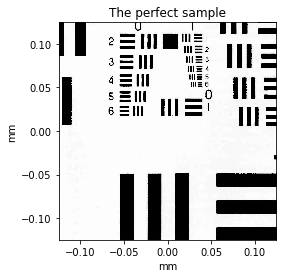

In [3]:
#Define sample absorption
sample = plt.imread('resolution_target.png')
sample = sample/sample.max()

#Add in sample phase delay 
sample_phase = sample
optical_thickness = 20 * wavelength
sample = sample * np.exp(1j * sample_phase*optical_thickness/wavelength) 
#complex exponential represents phase delay


#show absolute value of sample = its absorption
plt.figure()
plt.imshow(np.abs(sample), extent=(x[0], x[-1], y[0], y[-1]))
plt.title('The perfect sample')
plt.xlabel('mm');  plt.ylabel('mm'); plt.gray()

Next, let's model a plane wave hitting this thin sample. I've written down the general form of a plane wave for you guys below. Note that you can simulate the plane wave such that it hits the sample at any desired angle ($\theta_x$,$\theta_y$).

In [13]:
from scipy.signal import convolve2d as conv

In [ ]:
#Define plane wave
plane_wave_angle_x = 0 * np.pi/180
plane_wave_angle_y = 0 * np.pi/180
illumination_plane_wave = np.exp(1j*2*np.pi/wavelength * (np.sin(plane_wave_angle_x) * xx + np.sin(plane_wave_angle_y) * yy))

#Define field emerging from sample
emerging_field = conv(illumination_plane_wave, sample, mode='same')                     
                      

Now, let's propagate this field to the lens aperture plane via a Fourier transform, to create the sample spectrum. It is also helpful to define a set of coordinates $(f_x,f_y)$ at this Fourier transform plane. You can use the $(x,y)$ coordinates that you formed above, as well as the relationship $2f_x^{max}=1/\Delta x$, to define the $(f_x,f_y)$ coordinates. That is,  the full range of the spatial frequency axis is inversely proportional to the smallest step size in the spatial axis. Please go ahead and plot the magnitude of the sample spectrum with a set of marked and labeled axes (like for the sample in space). It is helpful to plot it on a log scale for visualization.

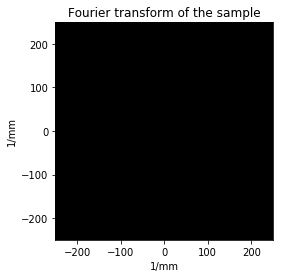

In [5]:
#define total range of spatial frequency axis, 1/mm
fmax = 1/delta_x
starting = -fmax
ending = fmax

#make linspace, meshgrid as needed
fx = np.linspace(starting, ending, num=num_samples)
fy = np.linspace(starting, ending, num=num_samples)
[fxx, fyy] = np.meshgrid(fx,fy)

# Take 2D fourier transform of sample
FT_sample = np.fft.fft2(sample)

# plot the Fourier transform of the sample in inverse mm coordinates
plt.figure()
plt.imshow( np.log(np.abs(FT_sample)), extent= (fx[0], fx[-1], fy[0], fy[-1])  )
plt.title('Fourier transform of the sample')
plt.xlabel('1/mm');  plt.ylabel('1/mm'); plt.gray()

In [6]:
np.shape(FT_sample)

(1000, 1000)

Next, define the lens transfer function as a circle with a finite radius in the spatial frequency domain. Inside the circle the value of the transfer function is 1, and outside it is 0. Let's make the lens transfer function diameter 1/4th the total spatial frequency axis coordinates. The diameter is set by a parameter called the lens numerical aperture. 

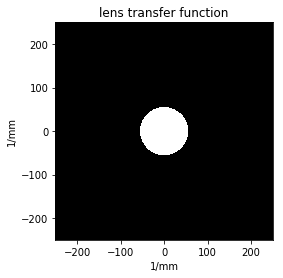

In [7]:
#Define lens numerical aperture as percentage of total width of spatial freqeuncy domain
L = ending-starting
d = 1/4*L

#Define lens transfer function as matrix with 1's within desired radius, 0's outside
lens = np.zeros(np.shape(FT_sample))
for i in range(0,1000):
    for j in range(0,1000):
        if (i-500)**2+(j-500)**2<=np.pi*(d/2)**2:
            lens[i,j] = 1
            
# Plot what the transfer function looks like
plt.imshow(lens, extent = (-250,250,-250,250))
plt.title('lens transfer function')
plt.xlabel('1/mm');  plt.ylabel('1/mm'); plt.gray()

In [8]:
np.shape(lens)

(1000, 1000)

You can now filter the sample spectrum with the lens transfer function, propagate this filtered spectrum to the image plane, and sample it on a detector that only detects the intensity of light, as we've shown in class. Let's assume the magnification of the lens is 5X (meaning the image of the sample at the detector plane is 5X larger than it is at the lens plane). Please display the resulting image on a new coordinate system, $(x',y')$ which represent the coordinates at the detector plane.

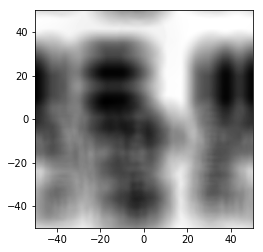

In [9]:
#Create filtered sample spectrum
len_filter = np.fft.fft2(lens)
filtered = FT_sample*len_filter

#Define spatial coordinates at image plane, using magnification
ix = np.linspace(starting/5, ending/5, num=num_samples)
iy = np.linspace(starting/5, ending/5, num=num_samples)
[ixx, iyy] = np.meshgrid(ix,iy)

#Propagate filtered sample spectrum to image plane
image = np.fft.ifft2(filtered)

#Detect intensity (squared magnitude) of resulting field on sensor
mag_image = np.abs(image)**2

#Plot resulting image
plt.imshow(mag_image, extent=(-50,50,-50,50))

Ok, you've simulated a microscope image! Great! Now let's try to change a few parameters to see what happens. Please try out the following tests and briefly answer the following questions:

(a) Let's try changing the illumination angle by 5 degrees. What happens to sample spectrum at the aperture plane? Why does that change the appearance of the image? Try again with a larger angle of illumination that changes the appearance of the image dramatically, such that the background of the image becomes black. This is called a dark field image. Why is there a transition from an image with a bright background to a dark background, and under what illumination angle conditions does this occur?

(b) Let's also change the lens numerical aperture. Instead of a circle having a diameter that is 25% the width of the frequency domain, let's try a smaller lens with 10%. How does the appearance of the image change? And why? Next, let's try a wider lens with 50%. Describe how the appearance of the image changes and why. 

(c) In the code that we provided, the sample both absorbed light and phase-delayed it at different locations across its surface. Now try to repeat the above exercise with a perfectly flat sample, that only absorbs light, and provides a constant phase delay across its surface. How does the sample spectrum change when you remove the phase delay term? How does this alter the appearence of the image, if at all, at different illumination angles?

(d) (bonus problem for extra credit) The lens aperture does not have to be a circle - it can be whatever shape you want. Go ahead and add an "apodizer" into the lens, which is (literally) a black circle marked onto the center of the lens. You can model this dark circle by making the center of the lens aperture circle zero, up to some first radius, then the lens aperture is 1 up to some second radius, and then the lens aperture ends and everything is zero again (this will form a ring). How does the appearance of the resulting image change, and why?



### (a)

### (b)

### (c)

### (d)

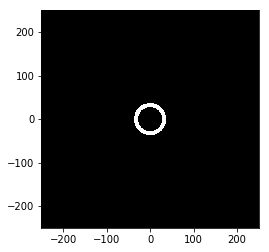

In [10]:
d1 = 1/8*L
d2 = 1/6*L
len2 = np.zeros(np.shape(FT_sample))
for i in range(0,1000):
    for j in range(0,1000):
        if (i-500)**2+(j-500)**2>=np.pi*(d1/2)**2 and (i-500)**2+(j-500)**2<=np.pi*(d2/2)**2:
            len2[i,j] = 1

plt.imshow(len2,extent=(-250,250,-250,250))